In [42]:
import os
import mitsuba as mi
import matplotlib.pyplot as plt

output_data_folder = 'data'
scene_file = 'scenes/cbox/cbox.xml'

mi.set_variant('scalar_rgb')
scene = mi.load_file(scene_file)

In [14]:
# clear data if necessary
%rm -r data

In [15]:
# create data folder if necessary
os.makedirs(output_data_folder, exist_ok=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


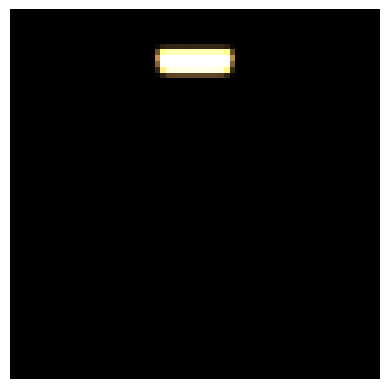

In [40]:
params = mi.traverse(scene)
params['logfile'] = 'data/gnn_file_1.path'
params.update();

ref_integrator = mi.load_dict({'type': 'path', 'max_depth': 5})
image = mi.render(scene, integrator=ref_integrator, spp=1000)

plt.axis("off")
plt.imshow(image ** (1.0 / 2.2)); # approximate sRGB tonemapping

#params = mi.traverse(scene)
#params['logfile'] = 'data/gnn_file_2.path'
#params.update();
#mi.render(scene, spp=20)

In [27]:
from mignn.container import SimpleLightGraphContainer
light_graphs1 = SimpleLightGraphContainer.fromfile('data/gnn_file_1.path', scene_file, verbose=True)
#light_graphs2 = SimpleLightGraphContainer.fromfile('data/gnn_file_2.path', scene_file, verbose=True)
print(f'{light_graphs1}')
#print(f'{light_graphs2}')

Load of `data/gnn_file_1.path` in progress: 100.00%
SimpleLightGraphContainer: [n_keys: 4096, n_graphs: 40960, n_nodes: 82175 (duplicate: 0), n_connections: 41215 (built: 0)]


In [28]:
from mignn.manager import LightGraphManager
merged_graph_container = LightGraphManager.fusion([light_graphs1])
print(merged_graph_container)

SimpleLightGraphContainer: [n_keys: 4096, n_graphs: 40960, n_nodes: 82175 (duplicate: 0), n_connections: 41215 (built: 0)]


In [29]:
merged_graph_container.build_connections(n_graphs=10, n_nodes_per_graphs=10, n_neighbors=10, verbose=True)

/home/jerome/Documents/Research/Development/Rendering/mitsuba3/build-gnn/python/drjit/router.py:1753: RuntimeWarning: divide by zero encountered in divide
  return 1.0 / arg
/home/jerome/Documents/Research/Development/Rendering/mitsuba3/build-gnn/python/drjit/generic.py:194: RuntimeWarning: invalid value encountered in scalar multiply
  ar[i] = a0[i] * a1


Connections build 100.00%


In [30]:
print(merged_graph_container)

SimpleLightGraphContainer: [n_keys: 4096, n_graphs: 40960, n_nodes: 106237 (duplicate: 24062), n_connections: 67543 (built: 26328)]


In [31]:
import torch
from torch_geometric.data import Data

graphs_samples = merged_graph_container.graphs_at((3, 3))

In [32]:
#############################################
# SEND COMMAND TO GL_PATHTRACING_VISUALIZER #
#############################################
import socket
import select
import time
import numpy as np

HOST = "127.0.0.1"
PORT = 8080
ACK_TEXT = 'text_received'

def upload_data_gl(graph_data):
    
    input("upload data to GL (y/n)")
    # instantiate a socket object
    print('socket instantiated')

    view_x, view_y, view_z = graph_data.pos[0]
    
    # gray color
    draw_point(view_x, view_y, view_z, 0.5, 0.5, 0.5)
    
    for (x, y, z) in graph_data.pos[1:]:
    
        # green color
        draw_point(x, y, z, 0, 0.7, 0)
        
    edge_index = np.array(graph_data.edge_index).T

    for c_i, (node_1, node_2) in enumerate(edge_index):
        x1, y1, z1 = graph_data.pos[node_1]
        x2, y2, z2 =graph_data.pos[node_2]
        
        tag_index = graph_data.edge_tag[c_i].value
        
        # expected build connection: then red else blue (original)
        if tag_index == 0:
            draw_line(x1, y1, z1, x2, y2, z2, 1, 0., 0)    
        else:
            draw_line(x1, y1, z1, x2, y2, z2, 0, 0.8, 0)

    stop()

def draw_point(x,y,z,r,g,b):

    sock = socket.socket()
    sock.connect((HOST, PORT))
    message = "drawpoint:"
    message = message + str(x) +","+str(y)+","+str(z)+";" # position
    message = message + str(r) +","+str(g)+","+str(b)+","+str(0)+";" # color
    sock.send(message.encode())
    # print("sending:", message)
    sock.close()

def draw_line(x,y,z, x2,y2,z2, r,g,b):

    sock = socket.socket()
    sock.connect((HOST, PORT))
    message = "drawline:"
    message = message + str(x) +","+str(y)+","+str(z)+";" # position
    message = message + str(x2) +","+str(y2)+","+str(z2)+";" # position2
    message = message + str(r) +","+str(g)+","+str(b)+","+str(0)+";" # color
    sock.send(message.encode())
    # print("sending:", message)
    sock.close()

def stop():
    sock = socket.socket()
    sock.connect((HOST, PORT))
    message = "STOP:0"
    sock.send(message.encode())
    sock.close()

In [34]:
graph_data = graphs_samples[4].data
print(graph_data)

GraphData(x=[[281.204, 276.166, -790.0, 0.292157, 0.288703, 0.911754], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], edge_index=[(0,), (1,)], edge_attr=(inf,), y=[0.0, 0.0, 0.0], edge_tag=(<ConnectionTag.ORIGINAL: 0>,), pos=[[281.204, 276.166, -790.0], [0.0, 0.0, 0.0]])


In [18]:
graph_data = graphs_samples[10].data
print(graph_data)
upload_data_gl(graph_data)

GraphData(x=[[281.368, 275.188, -790.0, 0.312563, 0.203045, 0.927942], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], edge_index=[(0,), (1,)], edge_attr=(inf,), y=[0.0, 0.0, 0.0], edge_tag=(<ConnectionTag.ORIGINAL: 0>,), pos=[[281.368, 275.188, -790.0], [0.0, 0.0, 0.0]])


KeyboardInterrupt: Interrupted by user